In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


In [31]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Load the training and testing parquet files
print("Loading datasets...")

# Find all parquet files in the archive(1) directory
#/home/garv/Desktop/Cyber-Security/archive (1)/Portmap-training.parquet
train_path = glob.glob('/home/garv/Desktop/Cyber-Security/archive (1)/*training.parquet')
test_path = glob.glob('/home/garv/Desktop/Cyber-Security/archive (1)/*testing.parquet')

print(f"Found {len(train_path)} training files and {len(test_path)} testing files")

# Load training data
train_data = pd.DataFrame()
for file in train_path:
    print(f"Loading train file: {file}")
    df = pd.read_parquet(file)
    train_data = pd.concat([train_data, df])

# Load testing data
test_data = pd.DataFrame()
for file in test_path:
    print(f"Loading test file: {file}")
    df = pd.read_parquet(file)
    test_data = pd.concat([test_data, df])

Loading datasets...
Found 7 training files and 10 testing files
Loading train file: /home/garv/Desktop/Cyber-Security/archive (1)/MSSQL-training.parquet
Loading train file: /home/garv/Desktop/Cyber-Security/archive (1)/NetBIOS-training.parquet
Loading train file: /home/garv/Desktop/Cyber-Security/archive (1)/Portmap-training.parquet
Loading train file: /home/garv/Desktop/Cyber-Security/archive (1)/LDAP-training.parquet
Loading train file: /home/garv/Desktop/Cyber-Security/archive (1)/Syn-training.parquet
Loading train file: /home/garv/Desktop/Cyber-Security/archive (1)/UDPLag-training.parquet
Loading train file: /home/garv/Desktop/Cyber-Security/archive (1)/UDP-training.parquet
Loading test file: /home/garv/Desktop/Cyber-Security/archive (1)/LDAP-testing.parquet
Loading test file: /home/garv/Desktop/Cyber-Security/archive (1)/NetBIOS-testing.parquet
Loading test file: /home/garv/Desktop/Cyber-Security/archive (1)/SNMP-testing.parquet
Loading test file: /home/garv/Desktop/Cyber-Security


Training data shape: (125170, 78)
Testing data shape: (306201, 78)

Training data columns: ['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag

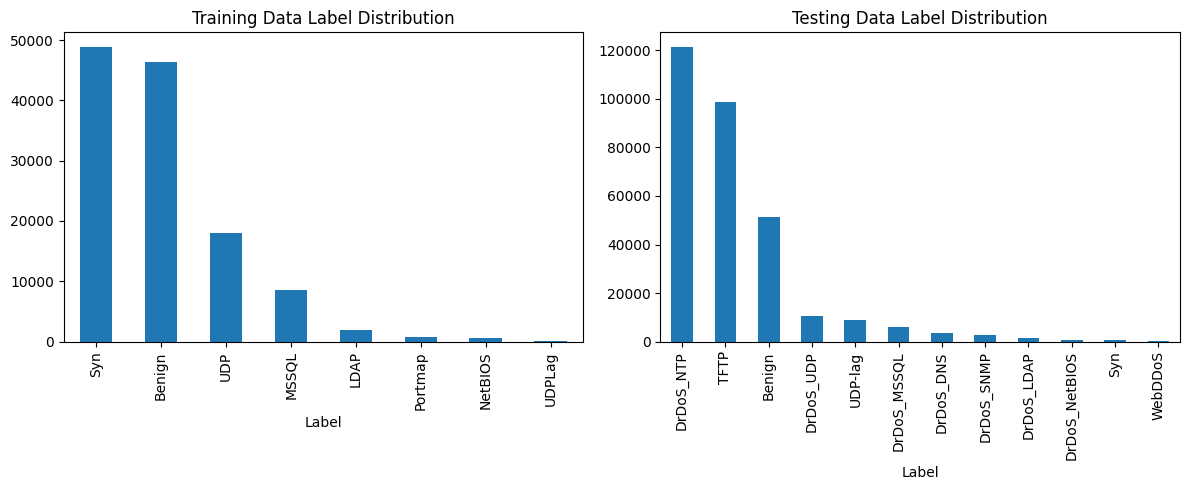

In [32]:
# 2. Explore the data
print("\nTraining data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)
print("\nTraining data columns:", train_data.columns.tolist())

# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum().sum())
print("Missing values in testing data:")
print(test_data.isnull().sum().sum())

# Display the distribution of the target variable
print("\nTarget variable distribution in training data:")
print(train_data["Label"].value_counts())
print("\nTarget variable distribution in testing data:")
print(test_data["Label"].value_counts())

# Visualize the class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data["Label"].value_counts().plot(kind='bar', title='Training Data Label Distribution')
plt.subplot(1, 2, 2)
test_data["Label"].value_counts().plot(kind='bar', title='Testing Data Label Distribution')
plt.tight_layout()
plt.show()


Creating binary labels...
Binary label distribution in training data:
binary_label
1    78743
0    46427
Name: count, dtype: int64

Binary label distribution in testing data:
binary_label
1    254797
0     51404
Name: count, dtype: int64


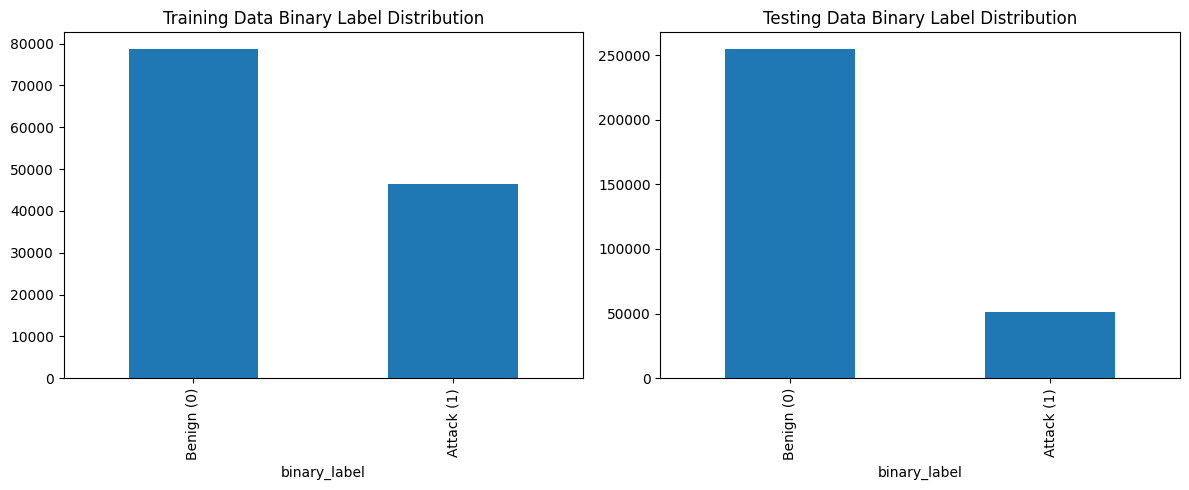

In [33]:
# 3. Preprocess the data
# Create binary labels (0 for benign, 1 for attack)
print("\nCreating binary labels...")
train_data['binary_label'] = train_data['Label'].apply(lambda x: 0 if x.lower() == 'benign' else 1)
test_data['binary_label'] = test_data['Label'].apply(lambda x: 0 if x.lower() == 'benign' else 1)

print("Binary label distribution in training data:")
print(train_data["binary_label"].value_counts())
print("\nBinary label distribution in testing data:")
print(test_data["binary_label"].value_counts())

# Visualize the binary class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data["binary_label"].value_counts().plot(kind='bar', title='Training Data Binary Label Distribution')
plt.xticks([0, 1], ['Benign (0)', 'Attack (1)'])
plt.subplot(1, 2, 2)
test_data["binary_label"].value_counts().plot(kind='bar', title='Testing Data Binary Label Distribution')
plt.xticks([0, 1], ['Benign (0)', 'Attack (1)'])
plt.tight_layout()
plt.show()

In [34]:
# 4. Prepare features and target variables
# Drop non-numeric columns and the original label
print("\nPreparing features...")
numeric_columns = train_data.select_dtypes(include=np.number).columns.tolist()
if 'Label' in numeric_columns:
    numeric_columns.remove('Label')
if 'binary_label' in numeric_columns:
    numeric_columns.remove('binary_label')

X_train = train_data[numeric_columns]
y_train = train_data['binary_label']
X_test = test_data[numeric_columns]
y_test = test_data['binary_label']

print(f"Number of features used: {len(numeric_columns)}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")



Preparing features...
Number of features used: 77
X_train shape: (125170, 77)
X_test shape: (306201, 77)


In [35]:
# 5. Scale the features
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Scaling features...


In [36]:
print("\nBuilding DNN model...")
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


Building DNN model...


/home/garv/Desktop/Cyber-Security/ryu39-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,033 (297.00 KB)

 Trainable params: 76,033 (297.00 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
print("\nTraining model...")
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=35,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


Training model...
Epoch 1/35
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9800 - loss: 0.0696 - val_accuracy: 0.9992 - val_loss: 0.0055
Epoch 2/35
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9950 - loss: 0.0195 - val_accuracy: 0.9990 - val_loss: 0.0047
Epoch 3/35
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9958 - loss: 0.0175 - val_accuracy: 0.9988 - val_loss: 0.0082
Epoch 4/35
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9962 - loss: 0.0153 - val_accuracy: 0.9983 - val_loss: 0.0044
Epoch 5/35
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9966 - loss: 0.0130 - val_accuracy: 0.9995 - val_loss: 0.0037
Epoch 6/35
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9967 - loss: 0.0133 - val_accuracy: 0.9983 - val_loss: 0.0052
Epoch 7/35
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9968 - loss: 0.0127 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 8/35
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.996

In [39]:
print("\nEvaluating model performance...")
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")



Evaluating model performance...
9569/9569 ━━━━━━━━━━━━━━━━━━━━ 7s 747us/step - accuracy: 0.8619 - loss: 0.3468
Test Loss: 0.2229
Test Accuracy: 0.9145


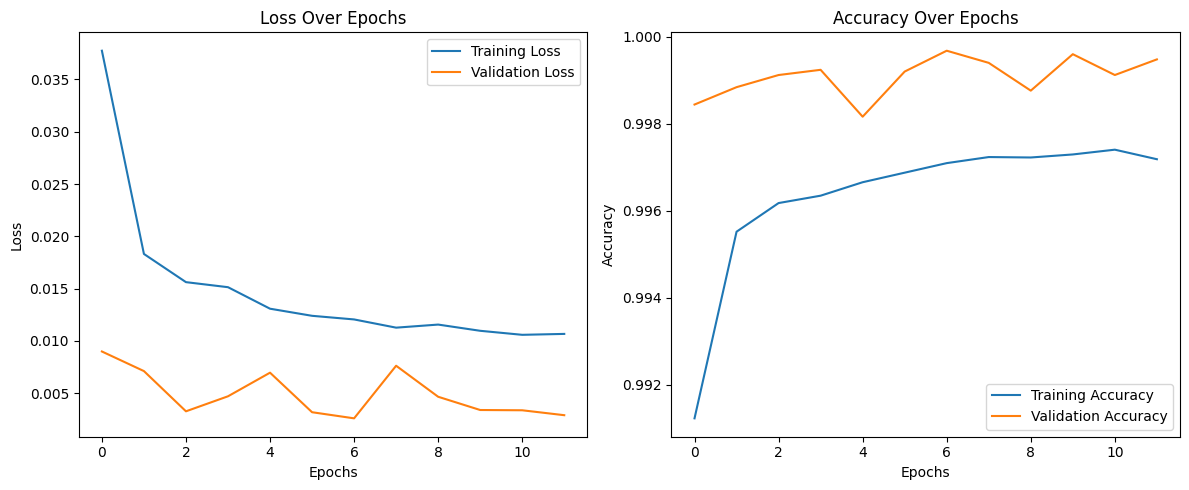

In [16]:
# 9. Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:












# 10. Make predictions and calculate more detailed metrics
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 11. Save the model
model.save('/home/garv/Desktop/Cyber-Security/ddos_detection_dnn_model.h5')
print("\nModel saved to: /home/garv/Desktop/Cyber-Security/ddos_detection_dnn_model.h5")


Building DNN model...


/home/garv/Desktop/Cyber-Security/ryu39-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1747757720.237028   13401 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747757720.238670   13401 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,033 (297.00 KB)

 Trainable params: 76,033 (297.00 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/20
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9783 - loss: 0.0727 - val_accuracy: 0.9991 - val_loss: 0.0064
Epoch 2/20
1340/1565 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9950 - loss: 0.0201

KeyboardInterrupt: 